In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, BaggingClassifier, VotingClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, roc_auc_score, roc_curve, f1_score, average_precision_score, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV , RandomizedSearchCV

from sklearn.inspection import permutation_importance

In [2]:
# from pycaret.classification import *

In [3]:
def get_pipeline_coefficients(Cs, pipeline, X_train, X_test, y_train, y_test, n_cv = 5, col_names = True):
    coefs = []
    f1_test = []
    f1_train = []
    f1_cv = []

    for c in Cs:
        pipeline.set_params(model__C = c)

        pipeline.fit(X_train, y_train)

        y_train_predict = pipeline.predict(X_train)
        f1_train.append(recall_score(y_train, y_train_predict, average = "weighted"))

        f1_cv.append(np.mean(cross_val_score(pipeline, X_train, y_train, cv = n_cv, scoring = "recall")))

        coefs.append(pipeline.named_steps["model"].coef_[0])
        
        y_predict = pipeline.predict(X_test)
        f1_test.append(recall_score(y_test, y_predict, average = "weighted"))

    df_results = pd.DataFrame(coefs)

    if col_names:
        df_results.columns = pipeline.named_steps["transformation"].get_feature_names_out()

    df_results.insert(0, "train_score", f1_train)
    df_results.insert(0, "cv_score", f1_cv)
    df_results.insert(0, "test_score", f1_test)
    df_results.insert(0, "Cs", Cs)

    return coefs, df_results

model_accuracy = {}
def model_evaluation(model_name, predictions, y):
    
    print(classification_report(y, predictions))
    print('----------------------------------------------------------')
    accuracy = recall_score(y, predictions, average = "weighted")
    print("Recall: %.2f%%" % (accuracy * 100))
    print('----------------------------------------------------------')
    
    model_accuracy[model_name] = accuracy

def plot_roc(model, y_test, proba_preds):

    # create linear line
    base_probs = [0 for _ in range(len(y_test))]

    lr_auc = roc_auc_score(y_test, proba_preds)

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, base_probs) # roc curve for the dummy model
    lr_fpr, lr_tpr, _ = roc_curve(y_test, proba_preds) # roc curve for your model

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Base')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model + ': ROC AUC = %.3f' % (lr_auc), loc='left')
    plt.legend()
    plt.show()

def plot_precision_recall(model, y_test, proba_preds):

    # create base line
    base_probs = [0 for _ in range(len(y_test))]

    lr_aps = average_precision_score(y_test, proba_preds)

    # calculate roc curves
    ns_pr, ns_rc, _ = precision_recall_curve(y_test, base_probs) # pr curve for the dummy model
    lr_pr, lr_rc, rg = precision_recall_curve(y_test, proba_preds) # pr curve for your model

    # F1 scores
    f1_lr = 2 * (lr_pr * lr_rc) / (lr_pr + lr_rc)

    # plot the pr curve for the model
    plt.plot(ns_rc, ns_pr, linestyle='--', label='Base')
    plt.plot(lr_rc, lr_pr, marker='.', label=model)
    plt.plot(rg, f1_lr[1:], linestyle='--', color = "red", label='F1')
    plt.xlabel('Recall (Positive label: 1)')
    plt.ylabel('Precision (Positive label: 1)')
    plt.title(model + ': AP = %.3f' % (lr_aps), loc='left')
    plt.legend()
    plt.show()

# Data Challenge -- Telcom Churn Prediction

Initial data cleaning and analysis

## Data Reading

We use `na_values = " "` to take care of missing values in the `TotalCharges` column

In [4]:
df_churn = pd.read_csv("../data/clean/telecom_users.csv")
# df_churn_one_hot = pd.read_csv("../data/clean/telecom_users_one_hot.csv")

In [5]:
df_churn_one_hot = pd.read_csv("../data/clean/telecom_users_one_hot.csv")

In [6]:
df_churn.shape

(5986, 19)

In [7]:
df_churn.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,Yes,Yes,72,2,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Automatic,24.10,1734.65,0
1,Female,0,No,No,44,1,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Automatic,88.15,3973.20,0
2,Female,1,Yes,No,38,2,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Automatic,74.95,2869.85,1
3,Male,0,No,No,4,1,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,0
4,Male,0,No,No,2,1,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,0


In [8]:
df_churn["SeniorCitizen"] = df_churn["SeniorCitizen"].map({0 : "No", 1 : "Yes"})

In [9]:
df_churn.dtypes

gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService          int64
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

## Initial Data Analysis

In [10]:
df_group = df_churn.groupby(by = ["SeniorCitizen"]).TotalCharges.sum().reset_index()
df_group["TotalCharges"] = df_group["TotalCharges"] / df_churn.TotalCharges.sum()
df_group

,SeniorCitizen,TotalCharges
0,No,0.804419
1,Yes,0.195581


In [11]:
df_group = df_churn.groupby(by = ["SeniorCitizen", "Partner", "Churn"]).TotalCharges.sum().reset_index()
df_group["TotalCharges"] = df_group["TotalCharges"] / df_churn.TotalCharges.sum()
df_group[df_group["Churn"] == 0]

,SeniorCitizen,Partner,Churn,TotalCharges
0,No,No,0,0.225496
2,No,Yes,0,0.452614
4,Yes,No,0,0.048325
6,Yes,Yes,0,0.094367


In [12]:
df_group = df_churn.groupby(by = ["SeniorCitizen", "Partner", "InternetService", "Churn"]).TotalCharges.sum().reset_index()
df_group["TotalCharges"] = df_group["TotalCharges"] / df_churn.TotalCharges.sum()
df_group[df_group["Churn"] == 1]

,SeniorCitizen,Partner,InternetService,Churn,TotalCharges
1,No,No,DSL,1,0.008383
3,No,No,Fiber optic,1,0.049640
5,No,No,No,1,0.000772
7,No,Yes,DSL,1,0.009928
9,No,Yes,Fiber optic,1,0.057023
11,No,Yes,No,1,0.000562
13,Yes,No,DSL,1,0.002564
15,Yes,No,Fiber optic,1,0.020488
17,Yes,No,No,1,0.000013
19,Yes,Yes,DSL,1,0.001782


In [13]:
df_group = df_churn.groupby(by = ["Contract", "Churn"]).TotalCharges.sum().reset_index()
df_group["TotalCharges"] = df_group["TotalCharges"] / df_churn.TotalCharges.sum()
df_group[(df_group["Churn"] == 1)]

,Contract,Churn,TotalCharges
1,Month-to-month,1,0.117995
3,One year,1,0.045144
5,Two year,1,0.016060


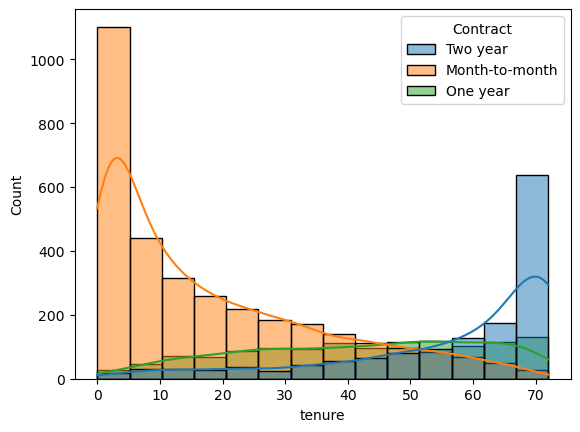

In [14]:
sns.histplot(data = df_churn, x = "tenure", hue='Contract', kde = "True", fill = True);

In [15]:
df_grouped = df_churn[(df_churn["tenure"] < 7)].groupby(by = ["Contract", "Churn"]).TotalCharges.sum().reset_index()
df_grouped["TotalCharges"] = 100 * df_grouped["TotalCharges"] / df_churn.TotalCharges.sum()
df_grouped 

,Contract,Churn,TotalCharges
0,Month-to-month,0,0.511881
1,Month-to-month,1,0.746723
2,One year,0,0.017395
3,One year,1,0.002997
4,Two year,0,0.018462


## Feature Engineering

In [16]:
# df_churn["Average_Payment"] = df_churn["TotalCharges"] / (1 + df_churn["tenure"])

In [17]:
numerical_variables = df_churn.select_dtypes(exclude = ["object"]).columns.to_list()
categorical_variables = df_churn.select_dtypes(include = ["object"]).columns.to_list()

In [18]:
print(numerical_variables)

['tenure', 'PhoneService', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [19]:
print(categorical_variables)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


## Exploratory Data Analysis

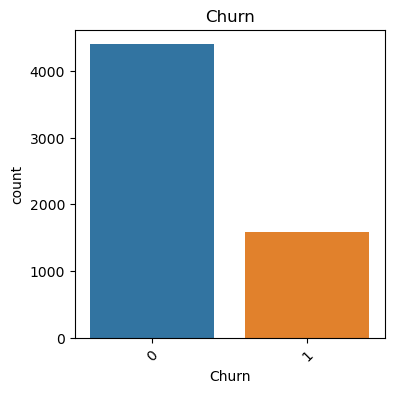

In [20]:
fig, ax = plt.subplots(sharex=False, sharey=False, figsize = (4, 4))
sns.countplot(data = df_churn, x = "Churn", ax = ax)
ax.tick_params(axis='x', rotation=45)
ax.set_title("Churn");

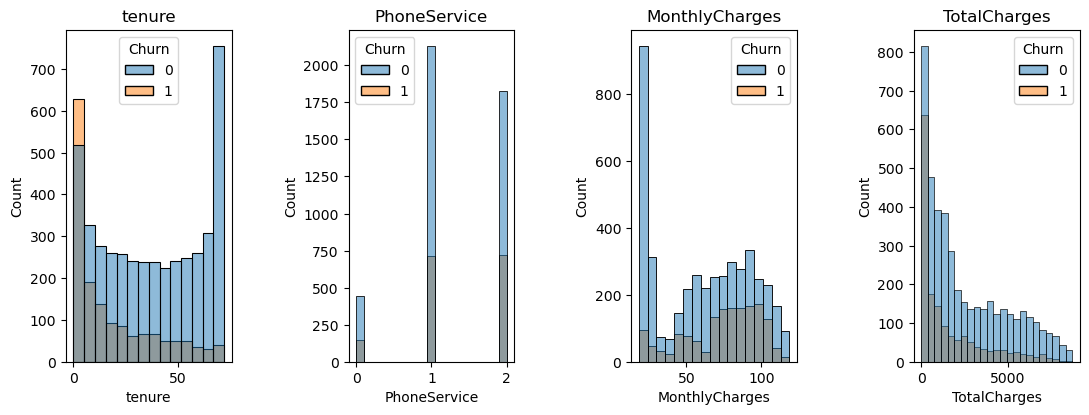

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False, figsize = (12, 5))
fig.tight_layout(pad = 5)
ax = ax.flatten()
for i, nc in enumerate(numerical_variables[:-1]):
    sns.histplot(data = df_churn, x = nc, hue='Churn', fill = True, ax = ax[i])
    ax[i].set_title(nc)

*QUESTIONS:*

- Where is the money coming from?
  - Young people
  - Implement a strategy to solve this problem
  - In the adults there are factor that we cannot influence : Kids leaving home, no need for internet? Death? -> Different strategy
  
- OpticalFiber:
  - 15% of the income leaves w/FO
  - Age/Status does not play a role
  - What are the reasons? How can we get more feedback? Is the costumer service the problem or the implementation? Survey?
  
- Tenure:
  - The first five months are decisive, what actions can we take there?
  - Can we offer a promotion? Adapt negotiation range and incentice people to stay at early stages?
  
- Month-to-Month:
  - Why are they leaving? Campaign to retain?
  - We see that 
  
- From those that have Streaming? What is their customer satisfaction? We see people leaving in both fronts
  
- Tech support? How much money do we lose there? How much does it cost a lost support? Cost-Benefit Analysis

- Does the partner have more expensive packages?
  - Married people earned more?
  - What type of packages?

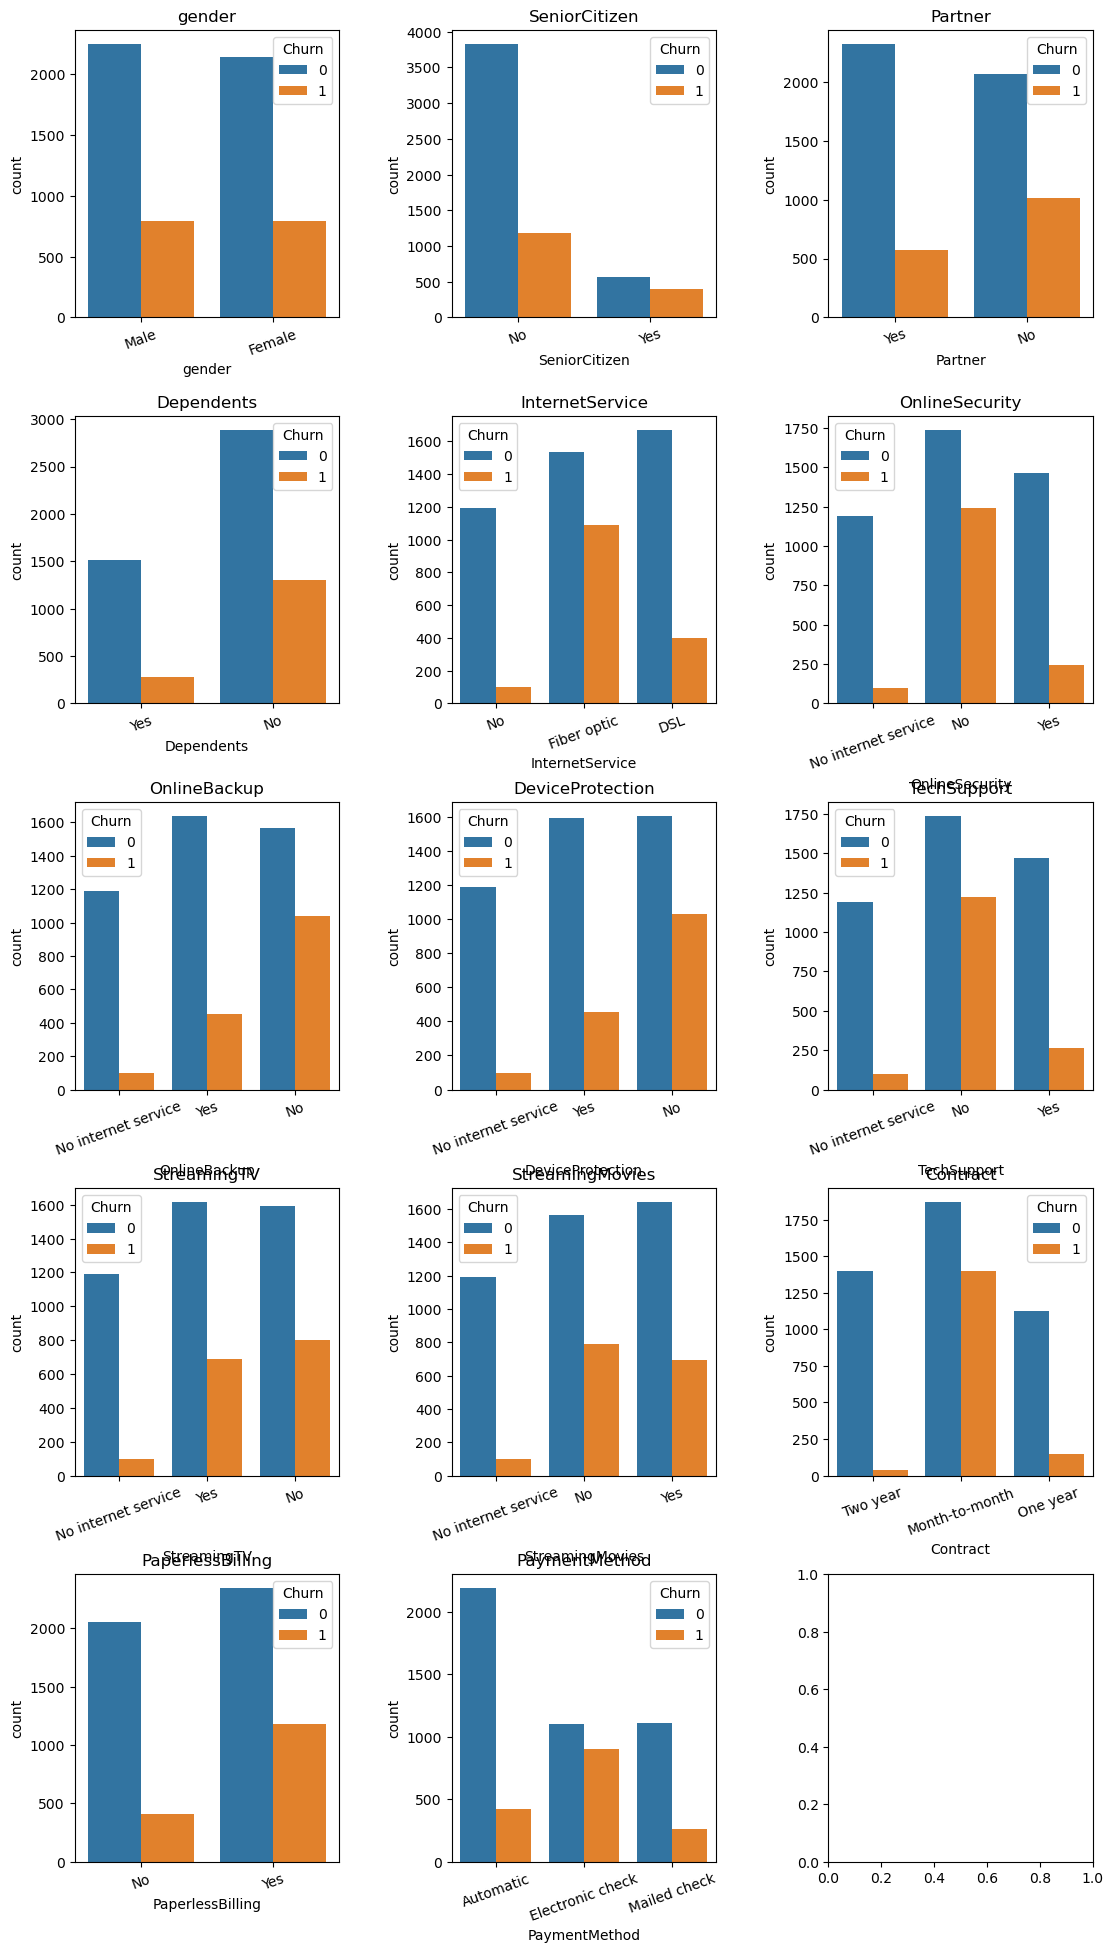

In [22]:
fig, ax = plt.subplots(nrows=5, ncols=3, sharex=False, sharey=False, figsize = (12, 20))
fig.tight_layout(pad = 5)
ax = ax.flatten()
for i, nc in enumerate(categorical_variables):
    sns.countplot(data = df_churn, x = nc, hue='Churn', ax = ax[i])
    ax[i].tick_params(axis='x', rotation=20)
    ax[i].set_title(nc)

Lets explore linear dependencies in the data

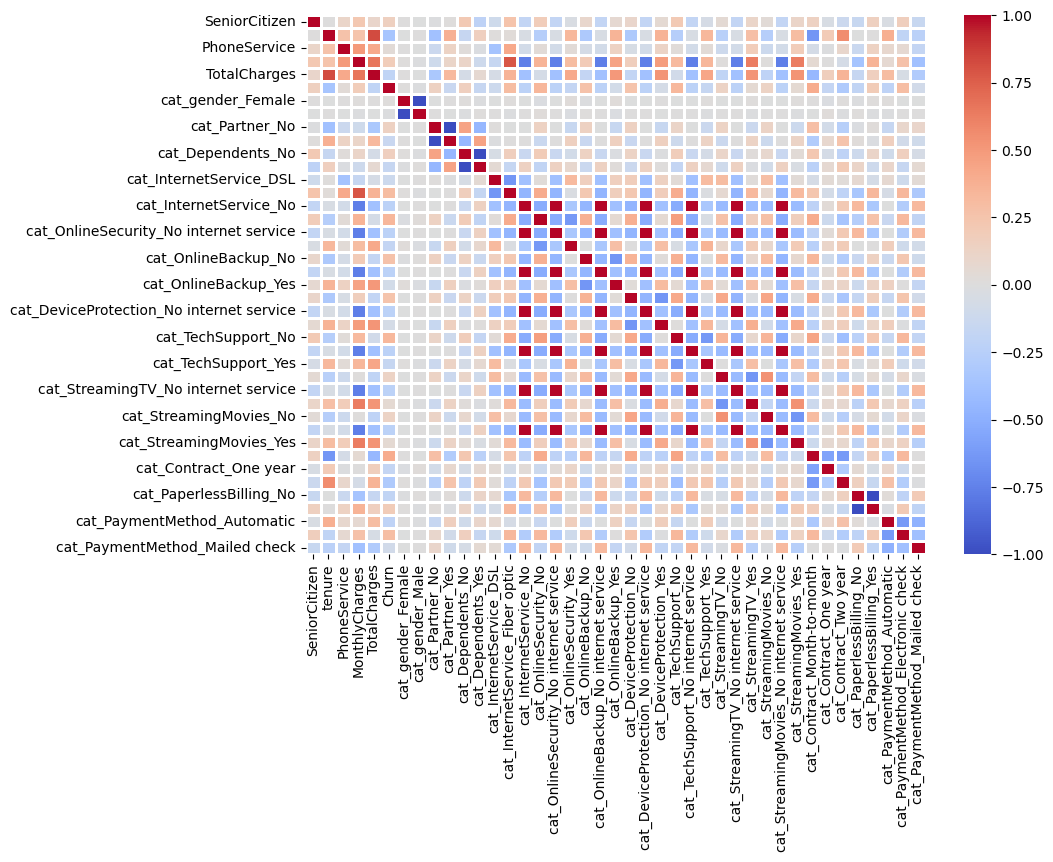

In [23]:
feature_corr = df_churn_one_hot.corr() # Definition of range of features to correlate
f,ax = plt.subplots(figsize=(10, 7)) # Defining the Size of our plot
sns.heatmap(feature_corr, annot=False, linewidths=1, fmt= '.1f',ax=ax, cmap = 'coolwarm')
plt.show();

## Model Fitting

### Data Spliting

In [24]:
X = df_churn.drop(columns=["Churn"])
y = df_churn["Churn"]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123, stratify = y)

In [26]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4788, 18) (1198, 18) (4788,) (1198,)


### Linear Regression

In [27]:
numerical_features = X.select_dtypes(exclude=["object"]).columns.to_list()
categorical_features = X.select_dtypes(include=["object"]).columns.to_list()

In [28]:
categorial_transformer = Pipeline(
    steps=[("one_hot_encoding", OneHotEncoder(handle_unknown="ignore"))]
)

numerical_transformer = Pipeline(
    steps = [("scaling", StandardScaler())]
)

preprocessing = ColumnTransformer(
    transformers = [
        ("numerical_processing", numerical_transformer, numerical_features),
        ("categorical_features", categorial_transformer, categorical_features)
    ]
)

In [29]:
p_regression_model = LogisticRegression(random_state = 123, penalty = "elasticnet", solver = "saga", C=6.905172413793103, l1_ratio=0.1)

In [30]:
pipeline_p_logistic_regression = Pipeline(
    steps = [
        ("transformation", preprocessing),
        ("model", p_regression_model)
    ]
)

In [31]:
pipeline_p_logistic_regression.fit(X_train, y_train)
y_pred = pipeline_p_logistic_regression.predict(X_test)

model_evaluation("elastic_net", y_pred, y_test)

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       880
           1       0.67      0.53      0.59       318

    accuracy                           0.80      1198
   macro avg       0.75      0.72      0.73      1198
weighted avg       0.79      0.80      0.80      1198

----------------------------------------------------------
Recall: 80.47%
----------------------------------------------------------


/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [32]:
num_features = list(pipeline_p_logistic_regression['transformation'].transformers_[0][2])
cat_features = list(pipeline_p_logistic_regression['transformation'].transformers_[1][1]['one_hot_encoding'].get_feature_names_out(categorical_features))
feature_cols = num_features + cat_features

/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

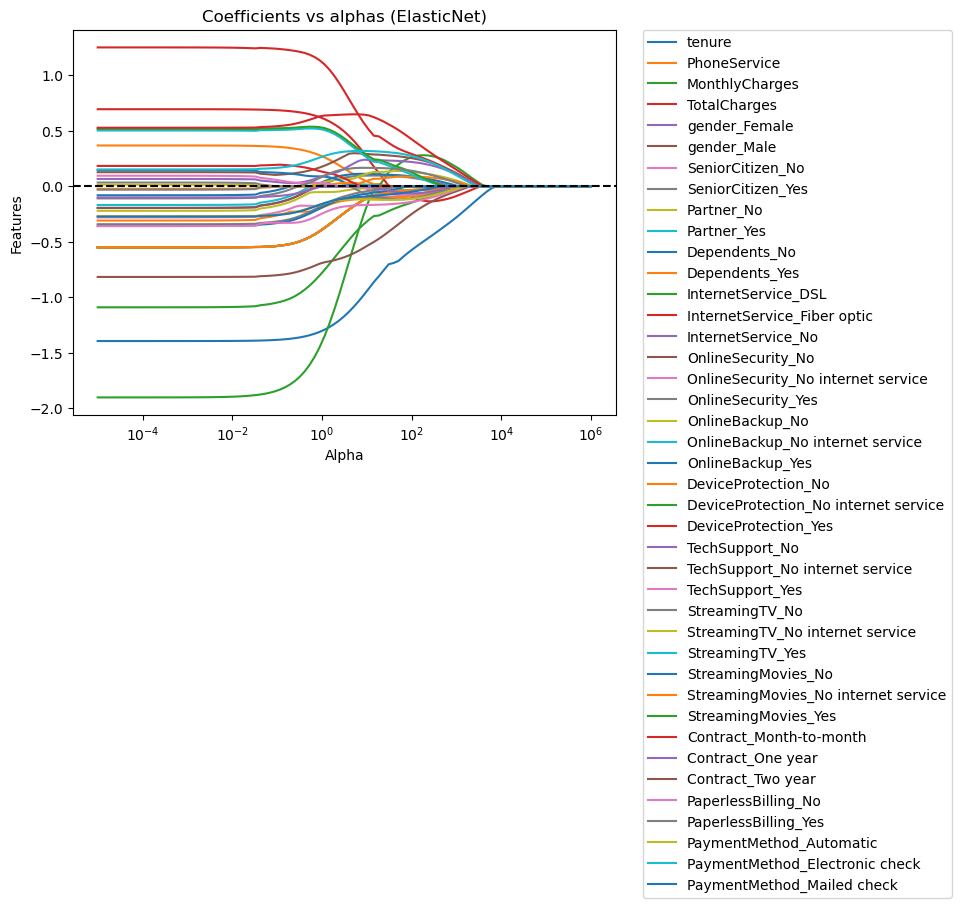

In [33]:
alphas = np.logspace(-5, 6, num = 101)
Cs = 1/alphas

lr_coefs, lr_results = get_pipeline_coefficients(Cs, pipeline_p_logistic_regression, X_train, X_test, y_train, y_test)

plt.subplots(figsize=[7,5])
plt.plot(alphas, lr_coefs)
plt.xscale("log")    # we apply log scale to have a better view
plt.title("Coefficients vs alphas (ElasticNet)")
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel("Alpha")
plt.ylabel("Features")
plt.legend(labels=feature_cols, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(False);

In [34]:
lr_results[lr_results["cv_score"] == lr_results["cv_score"].max()]# .head(1)

,Cs,test_score,cv_score,train_score,numerical_processing__tenure,numerical_processing__PhoneService,numerical_processing__MonthlyCharges,numerical_processing__TotalCharges,categorical_features__gender_Female,categorical_features__gender_Male,...,categorical_features__StreamingMovies_No internet service,categorical_features__StreamingMovies_Yes,categorical_features__Contract_Month-to-month,categorical_features__Contract_One year,categorical_features__Contract_Two year,categorical_features__PaperlessBilling_No,categorical_features__PaperlessBilling_Yes,categorical_features__PaymentMethod_Automatic,categorical_features__PaymentMethod_Electronic check,categorical_features__PaymentMethod_Mailed check
48,0.524807,0.800501,0.531116,0.802632,-1.241254,0.214293,-1.108899,0.559359,0.0,-0.001599,...,-0.308499,0.489569,0.642657,0.0,-0.66652,-0.201681,0.132035,-0.13061,0.298169,-0.126115


In [35]:
ln_coeff = lr_results[lr_results["cv_score"] == lr_results["cv_score"].max()].tail(1).T.reset_index().rename(columns = {48 : "coeff", "index" : "variable"}).query("coeff > 0 & variable.str.contains('__')").sort_values(by = "coeff", ascending = False)#.head()

In [36]:
ln_coeff["impact"] = 100 * ln_coeff["coeff"] / np.sum(ln_coeff["coeff"])
ln_coeff

,variable,coeff,impact
17,categorical_features__InternetService_Fiber optic,9.948304e-01,21.863009
37,categorical_features__Contract_Month-to-month,6.426574e-01,14.123437
7,numerical_processing__TotalCharges,5.593593e-01,12.292826
36,categorical_features__StreamingMovies_Yes,4.895695e-01,10.759082
33,categorical_features__StreamingTV_Yes,4.715506e-01,10.363087
43,categorical_features__PaymentMethod_Electronic...,2.981692e-01,6.552751
19,categorical_features__OnlineSecurity_No,2.259532e-01,4.965687
5,numerical_processing__PhoneService,2.142932e-01,4.709441
41,categorical_features__PaperlessBilling_Yes,1.320346e-01,2.901673
28,categorical_features__TechSupport_No,1.198100e-01,2.633020


## Other models

In [37]:
ML_models = {
    "logistic_regression" : {"model" : LogisticRegression(random_state = 123, penalty = None, solver = "saga"), "pipeline" : [], "cv_error" : 0, "train_error" : 0},
    "elastic_net_regression" : {"model" : LogisticRegression(random_state = 123, penalty = "elasticnet", C = 6.905172413793103, l1_ratio = 0.10, solver = "saga"), "pipeline" : [], "cv_error" : 0, "train_error" : 0},
    "knn": {"model" : KNeighborsClassifier(), "pipeline" : [], "cv_error" : 0, "train_error" : 0},
    "naive_bayes": {"model" : BernoulliNB(), "pipeline" : [], "cv_error" : 0, "train_error" : 0},
    "svm": {"model" : LinearSVC(random_state = 123, max_iter=10_000), "pipeline" : [], "cv_error" : 0, "train_error" : 0},
    "svm_rbf": {"model" : SVC(kernel = "rbf", gamma = "scale", random_state = 123), "pipeline" : [], "cv_error" : 0, "train_error" : 0},
    "decision_tree": {"model" : DecisionTreeClassifier(random_state = 123), "pipeline" : [], "cv_error" : 0, "train_error" : 0},
    "random_forest": {"model" : RandomForestClassifier(random_state = 123), "pipeline" : [], "cv_error" : 0, "train_error" : 0},
    "ada_boost" : {"model" : AdaBoostClassifier(random_state = 123), "pipeline" : [], "cv_error" : 0, "train_error" : 0},
    "gradient_boosting": {"model" : GradientBoostingClassifier(random_state = 123), "pipeline" : [], "cv_error" : 0, "train_error" : 0},
    "xgboost": {"model" : XGBClassifier(random_state = 123), "pipeline" : [], "cv_error" : 0, "train_error" : 0},
    "lightgbm": {"model" : LGBMClassifier(random_state = 123), "pipeline" : [], "cv_error" : 0, "train_error" : 0}
}

In [38]:
for name, model in ML_models.items():

    model["pipeline"] = Pipeline(
        steps = [
            ("transformation", preprocessing),
            ("model", model["model"])
            ]
            )
    
    model["pipeline"].fit(X_train, y_train)
    y_pred = model["pipeline"].predict(X_train)

    model["train_error"] = recall_score(y_train, y_pred, average = "weighted")

    model["cv_error"] = np.mean(
        cross_val_score(
            model["pipeline"], 
            X_train, 
            y_train, 
            cv = 5, 
            scoring = "recall_weighted"
            )
            )

/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

In [39]:
results = []
for name, model in ML_models.items():
    results.append([name, model["train_error"], model["cv_error"]])

df_results = pd.DataFrame(results)
df_results.columns = ["Model", "Train_Error", "CV_Error"]
df_results.sort_values(by = "CV_Error", ascending = False, inplace = True)
df_results

,Model,Train_Error,CV_Error
9,gradient_boosting,0.829992,0.803882
5,svm_rbf,0.819967,0.801584
4,svm,0.803676,0.801377
1,elastic_net_regression,0.802840,0.800751
0,logistic_regression,0.803049,0.800332
8,ada_boost,0.808897,0.800332
11,lightgbm,0.891813,0.794063
7,random_forest,0.998747,0.790307
10,xgboost,0.950084,0.785505
2,knn,0.832080,0.763787


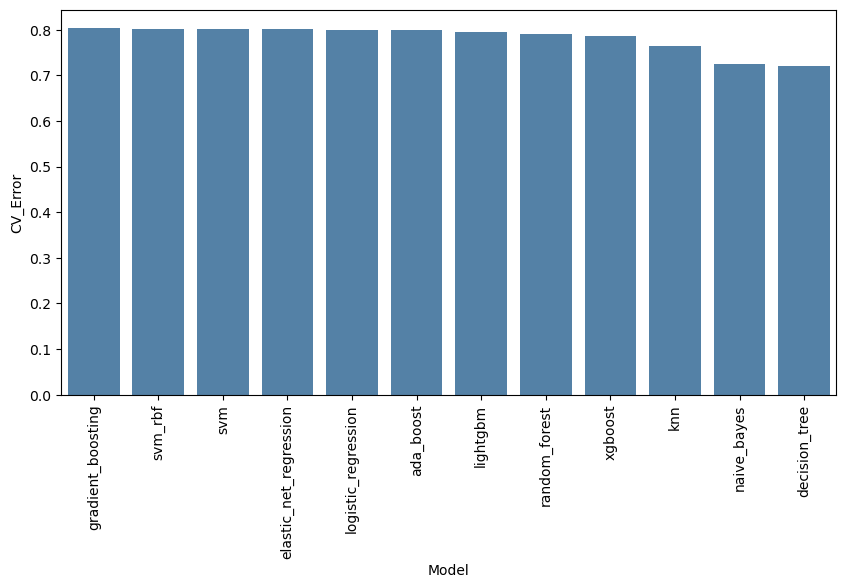

In [40]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.barplot(data = df_results, x="Model", y="CV_Error", color="Steelblue")
ax.tick_params(axis='x', rotation=90);

## Model Optimization

In [41]:
opt_results = {}

#### Elastic Net

In [42]:
ML_models["elastic_net_regression"]["pipeline"]

Pipeline(steps=[('transformation',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['tenure', 'PhoneService',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categorical_features',
                                                  Pipeline(steps=[('one_hot_encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('model',
                 LogisticRegression(C=6.905172413793103, l1_ratio=0.1,
                                    penalty='elasticnet', random_state=123,
                                    solver='saga'))])

In [43]:
parameters = [
    {
        "model__C" : np.linspace(0.01, 50.00, 30),
        "model__l1_ratio" : np.linspace(0.05, 0.5, 10),
    }
]

grid_obj = GridSearchCV(ML_models["elastic_net_regression"]["pipeline"], parameters, cv = 5, scoring = "recall_weighted")

In [44]:
grd_obj = grid_obj.fit(X_train, y_train)

/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

In [45]:
best_lm = grd_obj.best_estimator_
opt_results["elastic_net"] = np.mean(cross_val_score(best_lm, X_train, y_train, cv = 5, scoring = "recall_weighted"))

/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gordoaraujo/miniconda3/envs/dskit/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

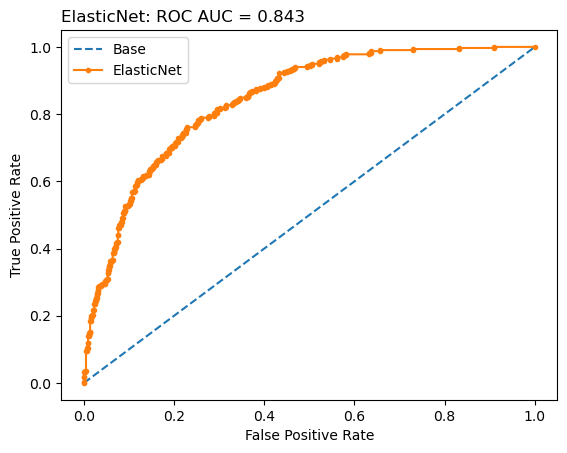

In [46]:
y_pred = best_lm.predict_proba(X_test)[:,1]
plot_roc("ElasticNet", y_test, y_pred)

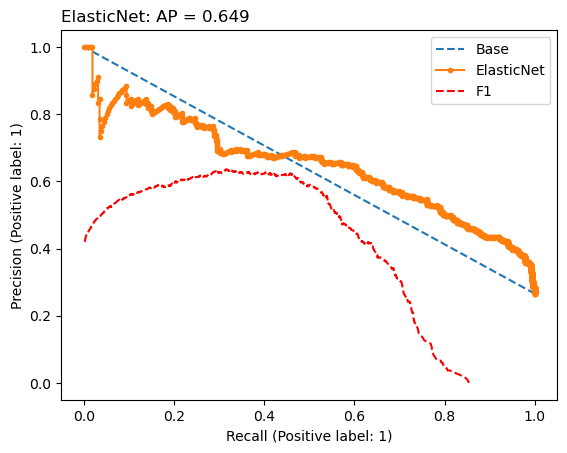

In [47]:
plot_precision_recall("ElasticNet", y_test, y_pred)

#### Gradient Boosting

In [48]:
ML_models["gradient_boosting"]["pipeline"]

Pipeline(steps=[('transformation',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['tenure', 'PhoneService',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categorical_features',
                                                  Pipeline(steps=[('one_hot_encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('model', GradientBoostingClassifier(random_state=123))])

In [49]:
parameters = {
    'model__n_estimators': [100, 500, 900],
    'model__max_depth': [2, 3, 10, 15],
    'model__min_samples_leaf': [2, 4, 8],
    'model__min_samples_split': [2, 4, 6, 10],
    'model__max_features': ['sqrt', 'log2']
    }

grid_obj = RandomizedSearchCV(ML_models["gradient_boosting"]["pipeline"], parameters, n_jobs=-1, cv = 5, scoring='recall_weighted', random_state = 123)

In [50]:
grd_obj = grid_obj.fit(X_train, y_train)

In [51]:
best_gb = grd_obj.best_estimator_
opt_results["gradient_boosting"] = np.mean(cross_val_score(best_gb, X_train, y_train, cv = 5, scoring = "recall_weighted"))

In [52]:
opt_results

{'elastic_net': 0.8007508676862936, 'gradient_boosting': 0.8036723145354634}

In [53]:
gb_importances = pd.DataFrame(
    {"feature": feature_cols, "importance": np.round(best_gb["model"].feature_importances_, 3)}
)
gb_importances = gb_importances.sort_values("importance", ascending=False).set_index(
    "feature"
)
gb_importances.head(20)

,importance
feature,
tenure,0.238
Contract_Month-to-month,0.120
InternetService_Fiber optic,0.102
TotalCharges,0.083
TechSupport_No,0.082
MonthlyCharges,0.064
Contract_Two year,0.057
PaymentMethod_Electronic check,0.054
OnlineSecurity_No,0.032


In [54]:
from sklearn.inspection import permutation_importance

gb_imp = permutation_importance(
    best_gb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2, scoring="recall_weighted"
)

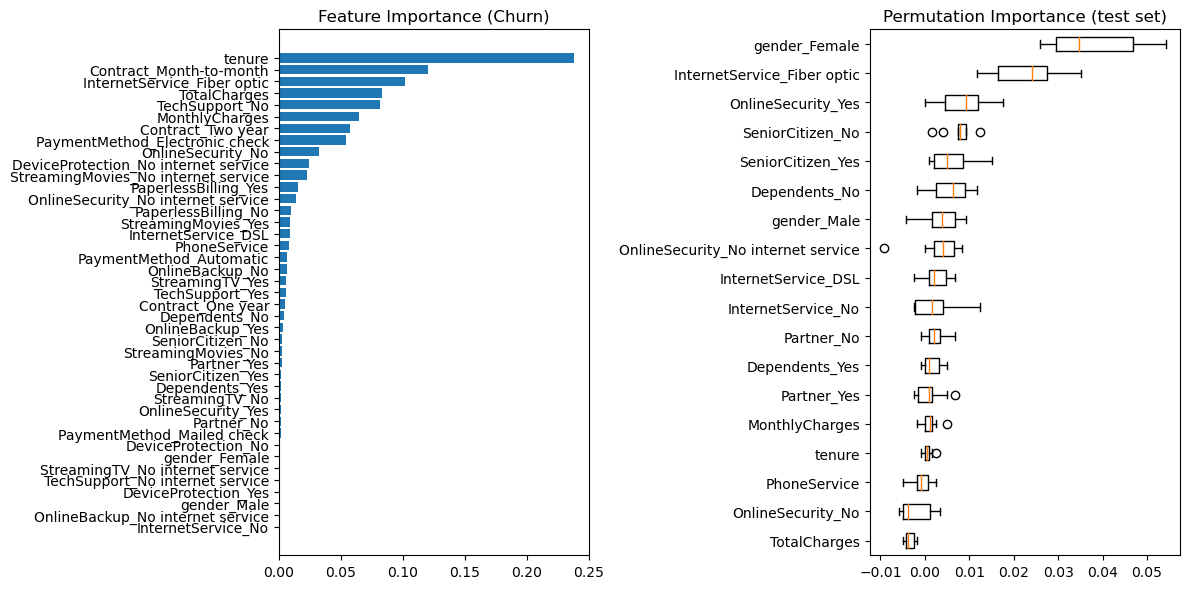

In [56]:
feature_importance = best_gb["model"].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_cols)[sorted_idx])
plt.title("Feature Importance (Churn)")

sorted_idx = gb_imp.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    gb_imp.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_cols)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

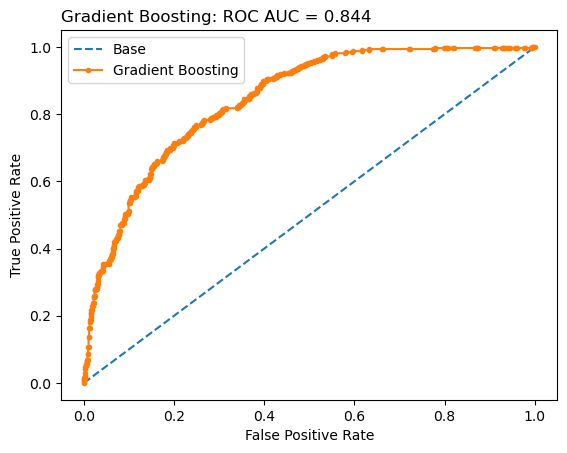

In [57]:
y_pred = best_gb.predict_proba(X_test)[:,1]
plot_roc("Gradient Boosting", y_test, y_pred)

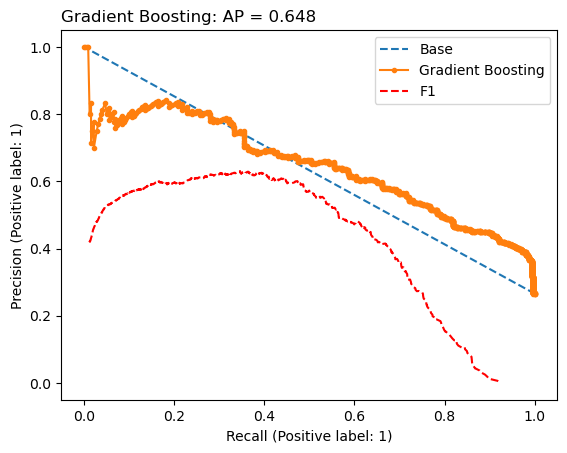

In [58]:
plot_precision_recall("Gradient Boosting", y_test, y_pred)

### Random Forest

In [59]:
ML_models["random_forest"]["pipeline"]

Pipeline(steps=[('transformation',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['tenure', 'PhoneService',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categorical_features',
                                                  Pipeline(steps=[('one_hot_encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('model', RandomForestClassifier(random_state=123))])

In [60]:
parameters = {
    'model__criterion': ['entropy', 'gini'],
    'model__n_estimators': [10, 20, 50, 100, 200],
    'model__max_features': ['sqrt', 'log2'],
    'model__max_depth': [3, 6, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__bootstrap': [True, False]}

grid_obj = RandomizedSearchCV(ML_models["random_forest"]["pipeline"], parameters, n_jobs=-1, cv = 5, scoring='recall_weighted', random_state = 123)

In [61]:
grd_obj = grid_obj.fit(X_train, y_train)

In [62]:
best_rf = grd_obj.best_estimator_
opt_results["random_forest"] = np.mean(cross_val_score(best_rf, X_train, y_train, cv = 5, scoring = "recall_weighted"))

In [63]:
opt_results

{'elastic_net': 0.8007508676862936,
 'gradient_boosting': 0.8036723145354634,
 'random_forest': 0.8007493406456764}

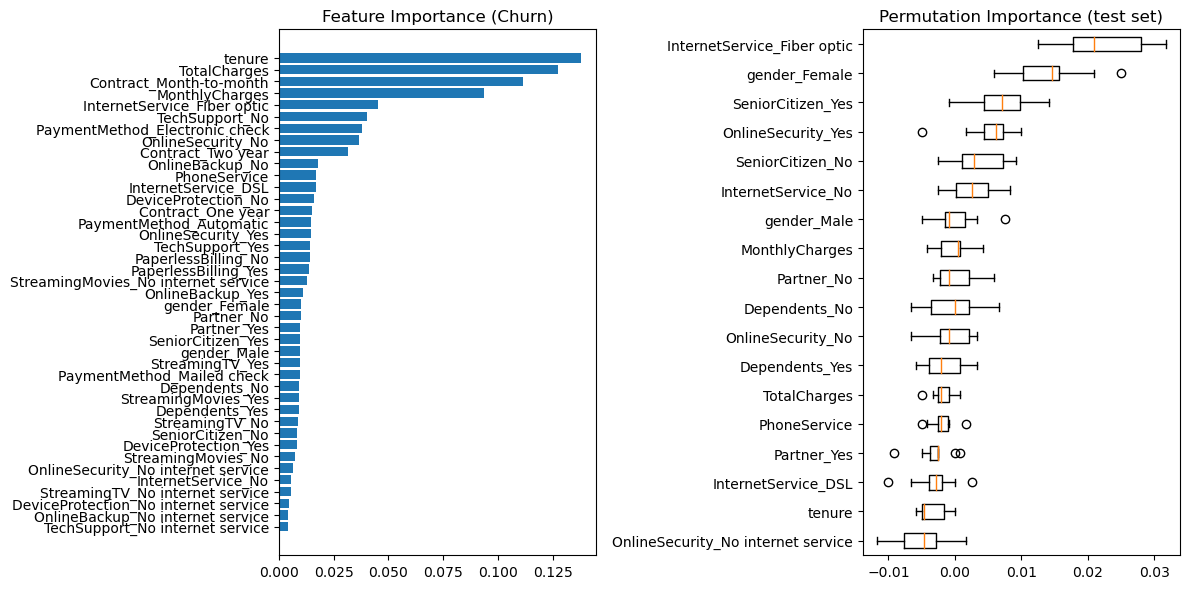

In [64]:
rf_imp = permutation_importance(
    best_rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2, scoring="recall_weighted"
)

feature_importance = best_rf["model"].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_cols)[sorted_idx])
plt.title("Feature Importance (Churn)")

sorted_idx = rf_imp.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    rf_imp.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_cols)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

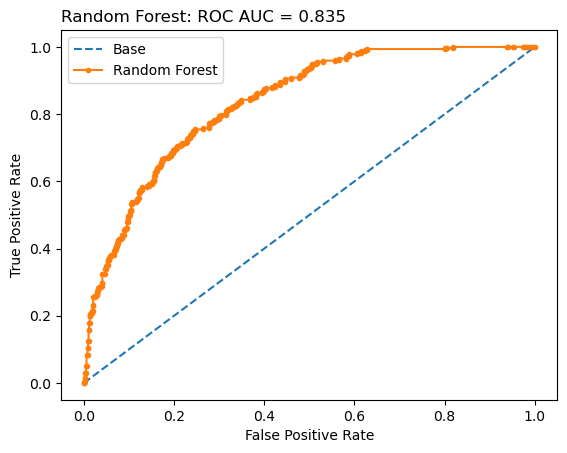

In [65]:
y_pred = best_rf.predict_proba(X_test)[:,1]
plot_roc("Random Forest", y_test, y_pred)

/var/folders/ln/drstgfk969nbzgwmb3txr0pc0000gn/T/ipykernel_14702/4106177046.py:77: RuntimeWarning: invalid value encountered in divide
  f1_lr = 2 * (lr_pr * lr_rc) / (lr_pr + lr_rc)


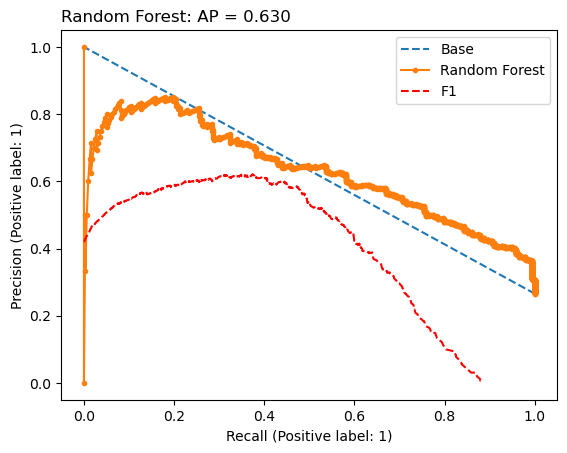

In [66]:
plot_precision_recall("Random Forest", y_test, y_pred)

### XGBoost

In [67]:
ML_models["xgboost"]["pipeline"]

Pipeline(steps=[('transformation',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['tenure', 'PhoneService',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categorical_features',
                                                  Pipeline(steps=[('one_hot_encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'In...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=123, ...))])

In [68]:
parameters = {
    'model__n_estimators': [100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.3],
    'model__booster': ['gbtree', 'gblinear'],
    'model__max_depth' : [3, 6, 10],
    'model__gamma': [0, 0.5, 1],
    'model__reg_alpha': [0, 0.5, 1, 5],
    'model__reg_lambda': [0, 0.5, 1, 5],
    'model__base_score': [0.20, 0.3, 0.5]
}

grid_obj = RandomizedSearchCV(ML_models["xgboost"]["pipeline"], parameters, n_jobs=-1, cv = 5, n_iter=20, scoring='recall_weighted', random_state = 123)

In [69]:
grd_obj = grid_obj.fit(X_train, y_train)

[23:23:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035139432/work/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[23:23:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035139432/work/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[23:23:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035139432/work/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[23:23:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035139432/work/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[23:23:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035139432/work/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[23:23:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035139432/work/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[23:23:47] WARNING: /Users/runner/

In [70]:
best_xgboost = grid_obj.best_estimator_
opt_results["xgboost"] = np.mean(cross_val_score(best_xgboost, X_train, y_train, cv = 5, scoring = "recall_weighted"))

[23:24:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035139432/work/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[23:24:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035139432/work/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[23:24:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035139432/work/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[23:24:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035139432/work/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.

[23:24:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1679035139432/work/src/learner.cc:767: 
Parameters: { "gamma", "max_depth" } are not used.



In [71]:
opt_results

{'elastic_net': 0.8007508676862936,
 'gradient_boosting': 0.8036723145354634,
 'random_forest': 0.8007493406456764,
 'xgboost': 0.7984533260035384}

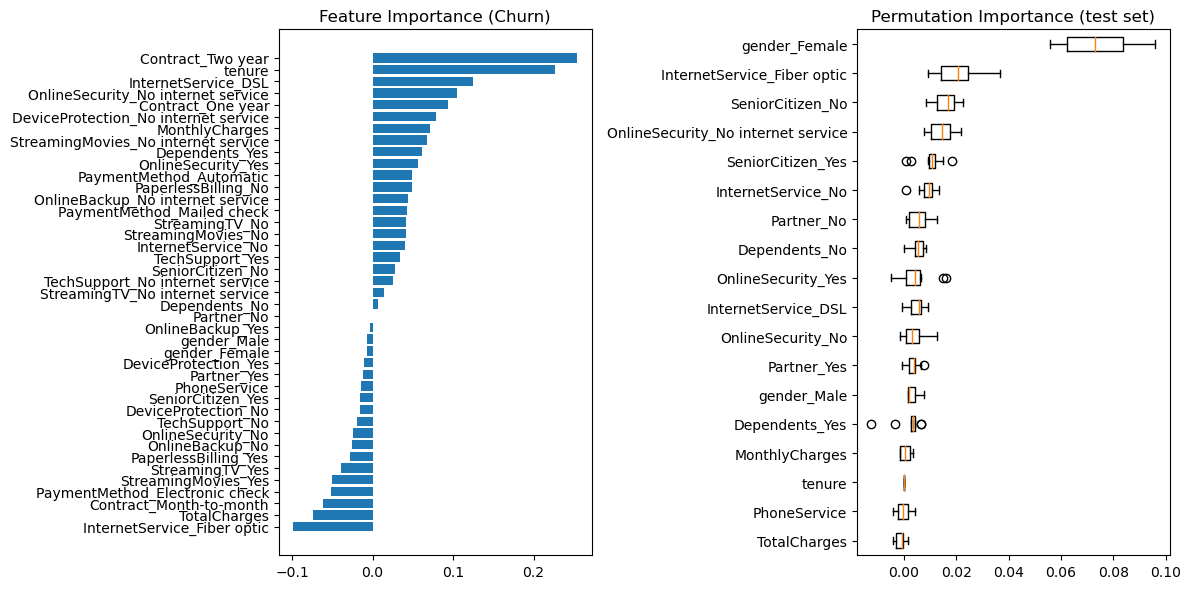

In [72]:
xgboost_imp = permutation_importance(
    best_xgboost, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2, scoring="recall_weighted"
)

feature_importance = best_xgboost["model"].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_cols)[sorted_idx])
plt.title("Feature Importance (Churn)")

sorted_idx = xgboost_imp.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    xgboost_imp.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_cols)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

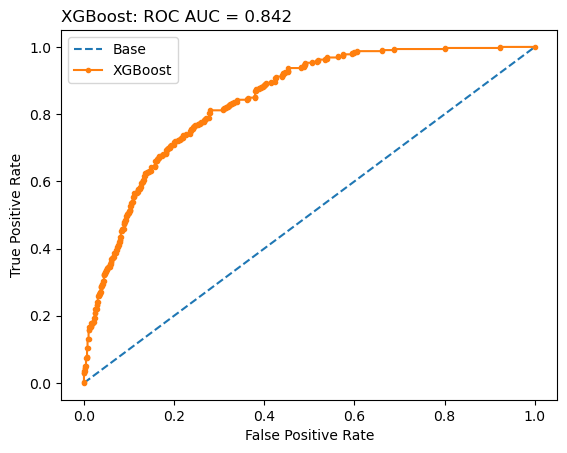

In [73]:
y_pred = best_xgboost.predict_proba(X_test)[:,1]
plot_roc("XGBoost", y_test, y_pred)

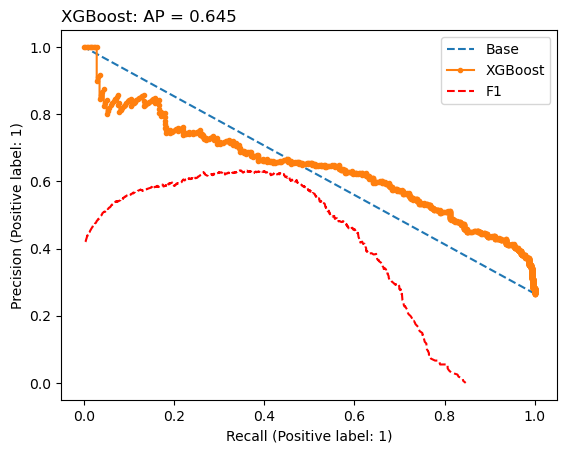

In [74]:
plot_precision_recall("XGBoost", y_test, y_pred)